<a href="https://colab.research.google.com/github/Huxwell/ColabNNs/blob/main/cats_n_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Jan  7 21:15:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import glob
from tqdm import tqdm
from PIL import Image
import random # do random.seed(13) before every shuffle. order of shuffle() execution changes results order.

Notes:
- I have no labels for test here, so I am dropping 'test.zip' related code. I can split train into train, val, test; in fact I don't want to have a lot of examples for train set.
- The sets are almost balanced, accuracy is ok here

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(13)
if device =='cuda':
    torch.cuda.manual_seed_all(13)

In [4]:
dataset_dir = '/content/drive/MyDrive/cats_n_dogs_unsure/dogs-vs-cats-redux-kernels-edition'
subset_bad_crops_path = '/content/drive/MyDrive/cats_n_dogs_unsure/cat_dogs_crops_from_test_20k_filtered.zip'
os.listdir(dataset_dir)

['sample_submission.csv', 'test.zip', 'train.zip']

In [5]:
os.makedirs('local_data/', exist_ok=True)
train_dir = 'local_data/train'

In [6]:
with zipfile.ZipFile(os.path.join(dataset_dir, 'train.zip')) as train_zip:
    train_zip.extractall('local_data')

with zipfile.ZipFile(subset_bad_crops_path) as bad_crops_zip:
    bad_crops_zip.extractall('local_data')

In [7]:
os.listdir(train_dir)[:5]

['cat.1181.jpg',
 'cat.8880.jpg',
 'dog.10519.jpg',
 'dog.11884.jpg',
 'dog.1007.jpg']

In [8]:
cats_list = sorted(glob.glob(os.path.join(train_dir,'cat*.jpg')))
dogs_list = sorted(glob.glob(os.path.join(train_dir,'dog*.jpg')))
bad_cats_generated_from_test_list = sorted(glob.glob(os.path.join("local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats",'cat*.jpg')))
bad_dogs_generated_from_test_list = sorted(glob.glob(os.path.join("local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs",'dog*.jpg')))
print(len(bad_cats_generated_from_test_list))
print(len(bad_dogs_generated_from_test_list))
print(len(cats_list))
print(len(dogs_list))
random.seed(13)
random.shuffle(cats_list)
random.seed(13) #multiple seed() executions are on purpose.
random.shuffle(dogs_list)
print(cats_list[:3])
print(dogs_list[:3])
# some sanity check to make sure no uncontrolled randomness beyond this point
assert cats_list[2] == 'local_data/train/cat.801.jpg'
assert dogs_list[2] == 'local_data/train/dog.801.jpg'
assert len(cats_list) == len(dogs_list)


random.seed(13)
random.shuffle(bad_cats_generated_from_test_list)
random.seed(13)
random.shuffle(bad_dogs_generated_from_test_list)
print(bad_cats_generated_from_test_list[:3])
print(bad_dogs_generated_from_test_list[:3])
assert bad_cats_generated_from_test_list[1] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.5232_crop_e_2.jpg'
assert bad_dogs_generated_from_test_list[1] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.3799_crop_e_2.jpg'

1866
1866
12500
12500
['local_data/train/cat.8473.jpg', 'local_data/train/cat.3808.jpg', 'local_data/train/cat.801.jpg']
['local_data/train/dog.8473.jpg', 'local_data/train/dog.3808.jpg', 'local_data/train/dog.801.jpg']
['local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.2865_crop_e_0.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.5232_crop_e_2.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.1459_crop_e_2.jpg']
['local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.2251_crop_e_1.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.3799_crop_e_2.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.1282_crop_e_1.jpg']


In [9]:
full_train_list = cats_list[:7500] + dogs_list[:7500]
# subset_train_list = cats_list[:500] + dogs_list[:500]
# subset_train_list = cats_list[:1000] + dogs_list[:1000]
# subset_train_list = cats_list[:2000] + dogs_list[:2000]
# subset_train_list = cats_list[:250] + dogs_list[:250]
# subset_train_list = cats_list[:150] + dogs_list[:150]
# subset_train_list = cats_list[:250] + dogs_list[:250] + bad_cats_generated_from_test_list[:100] + bad_dogs_generated_from_test_list[:100]
# subset_train_list = cats_list[:500] + dogs_list[:500] + bad_cats_generated_from_test_list[:200] + bad_dogs_generated_from_test_list[:200]

# subset_train_list = cats_list[:50] + dogs_list[:50] + bad_cats_generated_from_test_list[:20] + bad_dogs_generated_from_test_list[:20]
# subset_train_list = cats_list[:50] + dogs_list[:50] + bad_cats_generated_from_test_list[:20] + bad_dogs_generated_from_test_list[:20]

subset_train_list = cats_list[:2000] + dogs_list[:2000] + bad_cats_generated_from_test_list[:800] + bad_dogs_generated_from_test_list[:800]

val_list = cats_list[7500:10000] + dogs_list[7500:10000]
test_list = cats_list[10000:] + dogs_list[10000:]
print(len(subset_train_list),len(full_train_list), len(val_list), len(test_list))

random.seed(13)
random.shuffle(full_train_list)
random.seed(13)
random.shuffle(subset_train_list)
random.seed(13)
random.shuffle(val_list)
random.seed(13)
random.shuffle(test_list)
print("full",full_train_list[:9])
print("subset",subset_train_list[:9])
print("val",val_list[:9])
print("test",test_list[:9])
assert full_train_list[4] == 'local_data/train/cat.1612.jpg'
# assert subset_train_list[4] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.2922_crop_e_0.jpg' #500 + 200 bad crop imgs train
# assert subset_train_list[1] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_cats/cat.4044_crop_e_3.jpg' #1000 + 400 bad crop imgs train
# assert subset_train_list[3] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.4554_crop_e_2.jpg' #100 + 40 bad crop imgs train

assert subset_train_list[1] == 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.4650_crop_e_0.jpg' #2000 + 1600 bad crop imgs train

# assert subset_train_list[4] == 'local_data/train/cat.1787.jpg' #500imgs train
# assert subset_train_list[4] == 'local_data/train/cat.5360.jpg' #4000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.445.jpg' # 1000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.7661.jpg' # 300 imgs
# assert subset_train_list[4] == 'local_data/train/cat.9914.jpg' #100 imgs
# assert subset_train_list[4] == 'local_data/train/dog.11151.jpg'#2000imgs train
assert val_list[4] == 'local_data/train/dog.12023.jpg'
assert test_list[4] == 'local_data/train/dog.6485.jpg'

5600 15000 5000 5000
full ['local_data/train/dog.599.jpg', 'local_data/train/dog.1470.jpg', 'local_data/train/cat.682.jpg', 'local_data/train/dog.7470.jpg', 'local_data/train/cat.1612.jpg', 'local_data/train/cat.5301.jpg', 'local_data/train/dog.8695.jpg', 'local_data/train/cat.210.jpg', 'local_data/train/dog.10388.jpg']
subset ['local_data/train/dog.1044.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.4650_crop_e_0.jpg', 'local_data/train/dog.5532.jpg', 'local_data/train/dog.9326.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.2251_crop_e_1.jpg', 'local_data/train/dog.500.jpg', 'local_data/train/dog.1179.jpg', 'local_data/train/cat.10239.jpg', 'local_data/cat_dogs_crops_from_test_20k_filtered/filtered_dogs/dog.364_crop_e_1.jpg']
val ['local_data/train/dog.586.jpg', 'local_data/train/dog.1669.jpg', 'local_data/train/cat.1066.jpg', 'local_data/train/dog.5798.jpg', 'local_data/train/dog.12023.jpg', 'local_data/train/cat.10748.jpg', 'loca

In [10]:
train_list = subset_train_list # 5 batches # or 20 batches
# train_list = full_train_list

[1319  912 5456 2513 4795 2692 1667 2601 5057 2948]


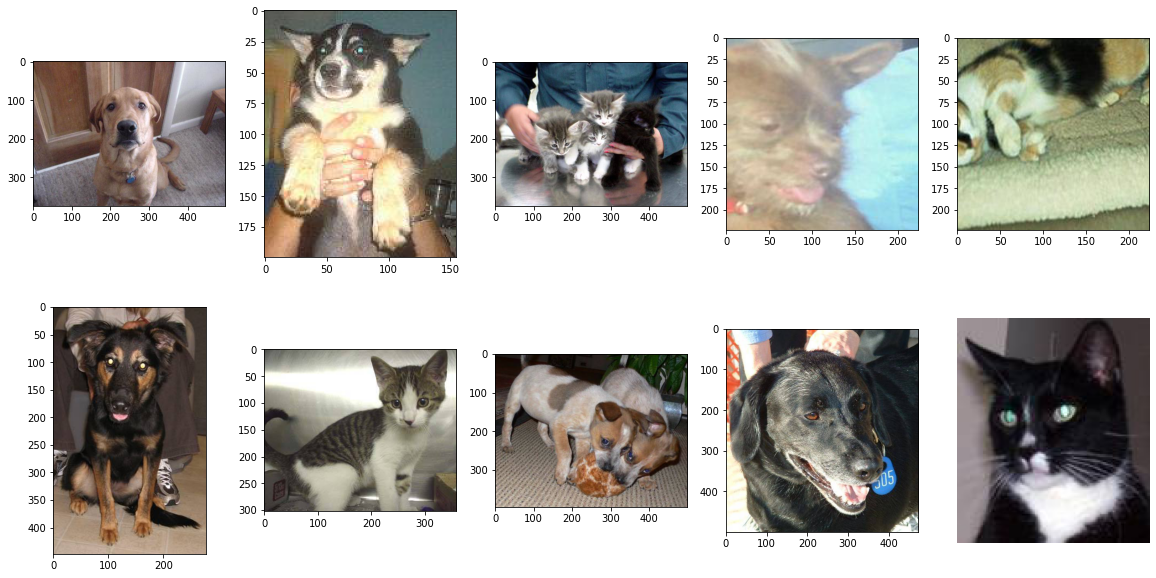

In [11]:
np.random.seed(1313131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = Image.open(train_list[img_idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [12]:
train_list[0].split('/')[-1].split('.')[0]

'dog'

# Data Augmentation

In [13]:
train_transforms =  transforms.Compose([ #these params work well for cats & dogs.:
  # transforms.Resize((224, 224)),
  transforms.RandomResizedCrop(224,scale=(0.9, 1.0)), 
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=.4, hue=.15),
  transforms.ToTensor(),
])

val_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transforms = transforms.Compose([   
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

In [14]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [15]:
## Visualization of Image Classification 
import torchvision
def visualize_classification(loader_iter, nrofItems = 9, pad = 0) -> None:

  #Iterate through the data loader
  imgTensor, labels = next(loader_iter)
  labels = labels.tolist()

  # Generate image grid
  grid = torchvision.utils.make_grid(imgTensor[:nrofItems], padding = pad, nrow=nrofItems)

  # Permute the axis as numpy expects image of shape (H x W x C) 
  grid = grid.permute(1, 2, 0)
  
  # Set up plot config
  plt.figure(figsize=(8, 2), dpi=300)
  plt.axis('off')

  # Plot Image Grid
  plt.imshow(grid)
  
  # # Plot the image titles
  # fact = 1 + (nrofItems)/100
  # rng = np.linspace(1/(fact*nrofItems), 1 - 1/(fact*nrofItems) , num = nrofItems)
  # for idx, val in enumerate(rng):
  #   plt.figtext(val, 0.85, labels[idx], fontsize=8)

  # Show the plot
  plt.show()

In [16]:
batch_size = 100 # we will use mini-batch method

In [17]:
train_data = dataset(train_list, transform=train_transforms)
val_data = dataset(val_list, transform=val_transforms)
test_data = dataset(test_list, transform=test_transforms)
visualise_train_dataset = dataset(train_list, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=False )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
vis_train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=False)

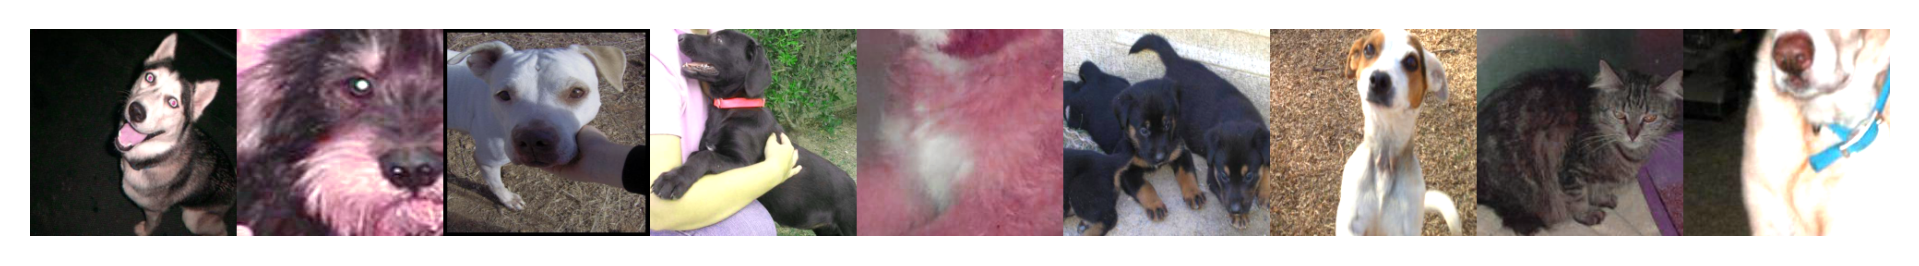

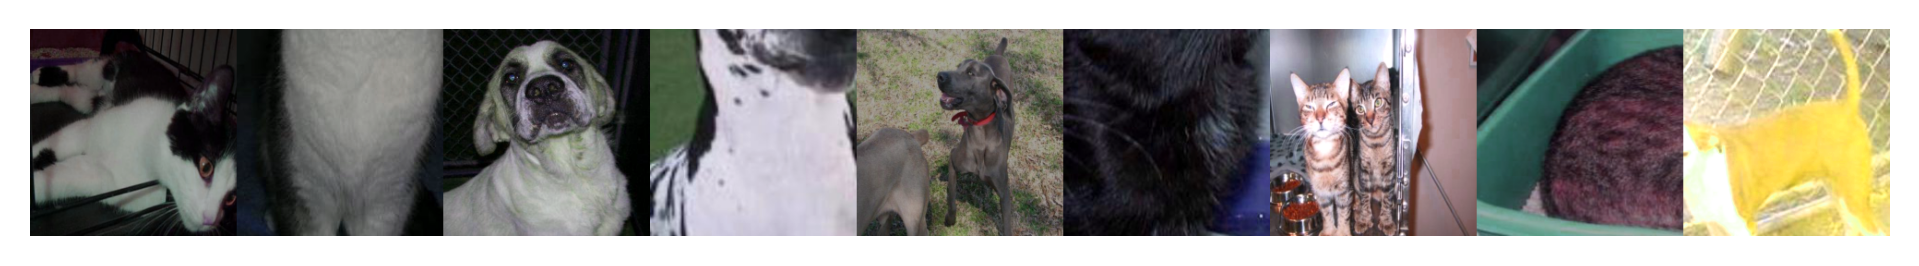

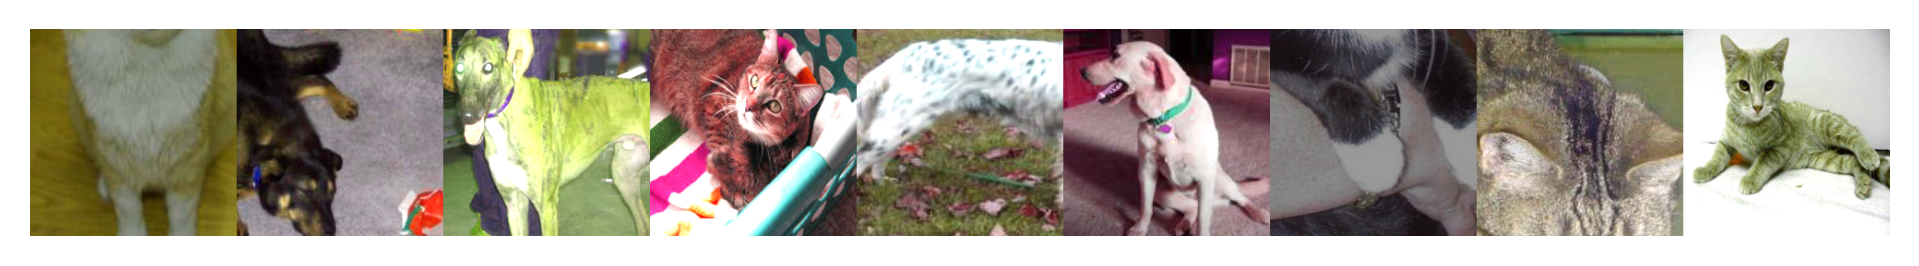

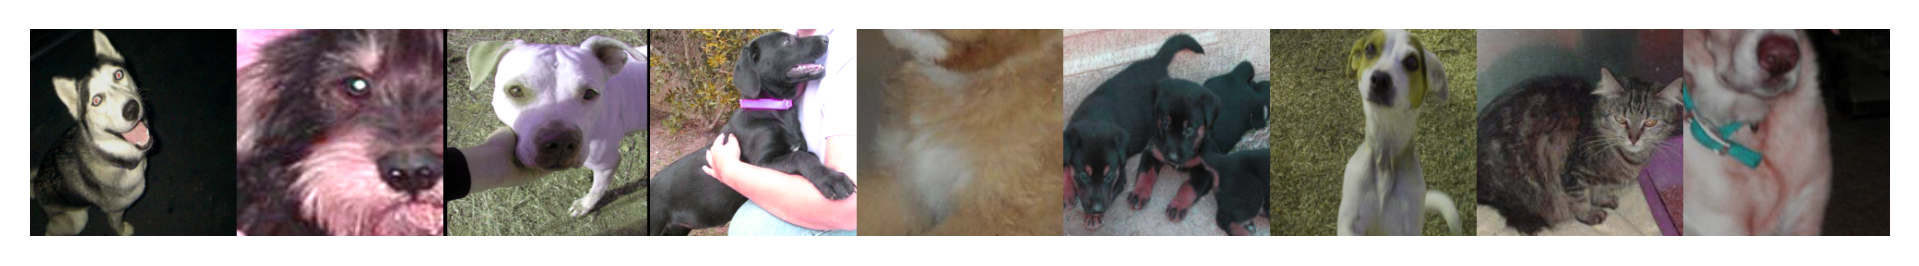

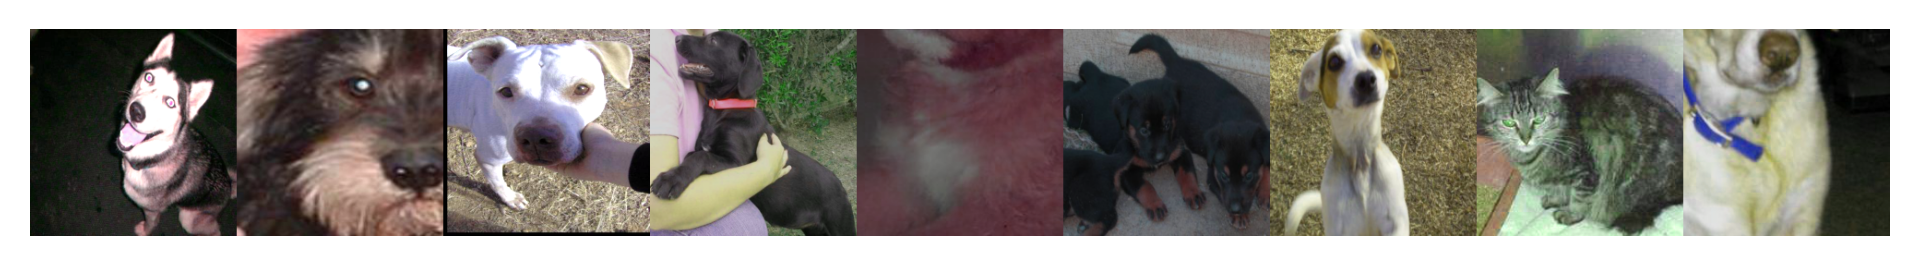

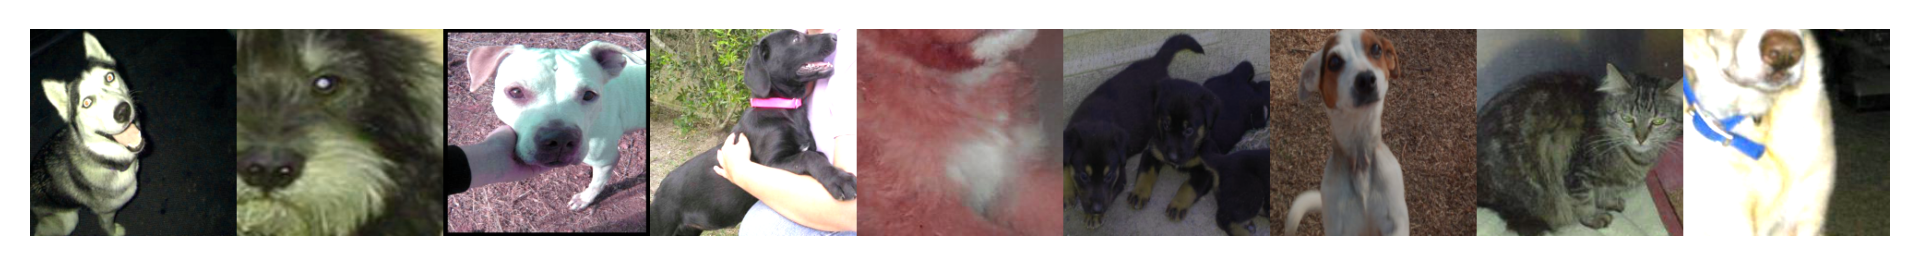

In [18]:
# this cell is here only because the Author apprently didn't understand how Dataset and Dataloaders behave - are they iterable, are they generators? - well they are hybrid. - , and wanted to see what happens
# all but one cell can be commented
# TODO: you don't need a separate loader. each iteration goes from the beginning
# but its interesting that different augmentations get generated.
iterator = iter(vis_train_loader)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))

In [19]:
print(len(train_data), len(train_loader), len(test_loader))

5600 56 50


In [20]:
print(sum(1 for filename in train_data.file_list if 'cat' in filename))
print(sum(1 for filename in train_data.file_list if 'dog' in filename))
print(sum(1 for filename in val_data.file_list if 'cat' in filename))
print(sum(1 for filename in val_data.file_list if 'dog' in filename))
print(sum(1 for filename in test_data.file_list if 'cat' in filename))
print(sum(1 for filename in test_data.file_list if 'dog' in filename))

3600
3600
2500
2500
2500
2500


In [21]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [22]:
class Experiment:
  epochs = 100 #10
  min_val_loss = float('inf')
  epochs_since_min_loss = 0
  patience = 7
  final_scores = {}  

  def __init__(self):
    self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False).to(device).train()
    self.optimizer = optim.Adam(params = self.model.parameters(),lr=0.001)
    self.criterion = nn.CrossEntropyLoss()

  def eval_model(self, loader: torch.utils.data.dataloader.DataLoader, model: nn.Module, description: str="Evaluation:") -> tuple: #[torch.Tensor, torch.Tensor] detailed tuple types only in Python >3.9, colab has 3.8.16
    epoch_accuracy=0
    epoch_loss =0
    with torch.no_grad():
      with tqdm(loader, unit="iteration") as tqdm_wrapped_loader:
        tqdm_wrapped_loader.set_description(description)
        for data, label in tqdm_wrapped_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = run.criterion(output,label)


            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/ len(loader)
            epoch_loss += loss/ len(loader)
            tqdm_wrapped_loader.set_postfix(epoch_accuracy=epoch_accuracy, loss=epoch_loss)
    return epoch_accuracy, epoch_loss

  def train(self):
      for epoch in range(self.epochs):
          print("\n","="*30,"\n")
          epoch_loss = 0
          epoch_accuracy = 0
          
          with tqdm(train_loader, unit="iteration") as tepoch:
            
            for data, label in tepoch:
                tepoch.set_description(f"Training epoch {epoch}")
                data = data.to(device)
                label = label.to(device)
                
                output = run.model(data)
                loss = run.criterion(output, label)
                
                run.optimizer.zero_grad()
                loss.backward()
                run.optimizer.step()
                
                acc = ((output.argmax(dim=1) == label).float().mean())
                epoch_accuracy += acc/len(train_loader)
                epoch_loss += loss/len(train_loader)
                tepoch.set_postfix(loss=loss.item(), accuracy=100. * epoch_accuracy)
            print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch, epoch_accuracy,epoch_loss))

          epoch_val_accuracy,epoch_val_loss = self.eval_model(val_loader, run.model, f"Validation after epoch {epoch}")
          print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch, epoch_val_accuracy,epoch_val_loss))
          scalar_val_loss = epoch_val_loss.item()
          if scalar_val_loss < self.min_val_loss:
            self.min_val_loss = scalar_val_loss 
            self.epochs_since_min_loss = 0 
            self.final_scores['epoch']=epoch
            self.final_scores['epoch_train_accuracy']=epoch_accuracy
            self.final_scores['epoch_train_loss']=epoch_loss
            self.final_scores['epoch_val_loss']=epoch_val_loss
            self.final_scores['epoch_val_accuracy']=epoch_val_accuracy


            print("New best model, min_val_loss:", self.min_val_loss)

            # epoch_test_accuracy,epoch_test_loss = self.eval_model(test_loader, model, f"Test after epoch {epoch}")
            # print('Epoch : {}, test_accuracy : {}, test_loss : {}'.format(epoch, epoch_test_accuracy,epoch_test_loss))



          else:
            self.epochs_since_min_loss+=1
            print("epochs_since_min_loss",self.epochs_since_min_loss)
          if self.epochs_since_min_loss > self.patience:
            print(f"Early stopping. \n\n Best model scores: {self.final_scores}")
            break

In [23]:
run = Experiment()
run.train()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training epoch 0: 100%|██████████| 56/56 [01:10<00:00,  1.26s/iteration, accuracy=tensor(55.4464, device='cuda:0'), loss=0.695]


Epoch : 0, train accuracy : 0.5544643402099609, train loss : 1.1159089803695679


Validation after epoch 0: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.6232, device='cuda:0'), loss=tensor(0.6491, device='cuda:0')]


Epoch : 0, val_accuracy : 0.6231998801231384, val_loss : 0.6490968465805054
New best model, min_val_loss: 0.6490968465805054




Training epoch 1: 100%|██████████| 56/56 [01:10<00:00,  1.26s/iteration, accuracy=tensor(60.1071, device='cuda:0'), loss=0.71]


Epoch : 1, train accuracy : 0.6010714173316956, train loss : 0.6666515469551086


Validation after epoch 1: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.6438, device='cuda:0'), loss=tensor(0.6281, device='cuda:0')]


Epoch : 1, val_accuracy : 0.6438000202178955, val_loss : 0.6281388998031616
New best model, min_val_loss: 0.6281388998031616




Training epoch 2: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(63.6607, device='cuda:0'), loss=0.663]


Epoch : 2, train accuracy : 0.6366071701049805, train loss : 0.6411120295524597


Validation after epoch 2: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.6746, device='cuda:0'), loss=tensor(0.6040, device='cuda:0')]


Epoch : 2, val_accuracy : 0.674599826335907, val_loss : 0.6039530038833618
New best model, min_val_loss: 0.6039530038833618




Training epoch 3: 100%|██████████| 56/56 [01:10<00:00,  1.26s/iteration, accuracy=tensor(66.8393, device='cuda:0'), loss=0.658]


Epoch : 3, train accuracy : 0.6683927774429321, train loss : 0.6152805685997009


Validation after epoch 3: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.7018, device='cuda:0'), loss=tensor(0.5812, device='cuda:0')]


Epoch : 3, val_accuracy : 0.7018000483512878, val_loss : 0.581171989440918
New best model, min_val_loss: 0.581171989440918




Training epoch 4: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(66.9643, device='cuda:0'), loss=0.616]


Epoch : 4, train accuracy : 0.6696428060531616, train loss : 0.6034925580024719


Validation after epoch 4: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.7132, device='cuda:0'), loss=tensor(0.5593, device='cuda:0')]


Epoch : 4, val_accuracy : 0.7131998538970947, val_loss : 0.5593042373657227
New best model, min_val_loss: 0.5593042373657227




Training epoch 5: 100%|██████████| 56/56 [01:10<00:00,  1.26s/iteration, accuracy=tensor(68.6429, device='cuda:0'), loss=0.612]


Epoch : 5, train accuracy : 0.6864286065101624, train loss : 0.5914677381515503


Validation after epoch 5: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.7234, device='cuda:0'), loss=tensor(0.5449, device='cuda:0')]


Epoch : 5, val_accuracy : 0.7233998775482178, val_loss : 0.544924259185791
New best model, min_val_loss: 0.544924259185791




Training epoch 6: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(70.6964, device='cuda:0'), loss=0.612]


Epoch : 6, train accuracy : 0.7069642543792725, train loss : 0.5592821836471558


Validation after epoch 6: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.7310, device='cuda:0'), loss=tensor(0.5373, device='cuda:0')]


Epoch : 6, val_accuracy : 0.7310000061988831, val_loss : 0.5373055934906006
New best model, min_val_loss: 0.5373055934906006




Training epoch 7: 100%|██████████| 56/56 [01:09<00:00,  1.25s/iteration, accuracy=tensor(71.7143, device='cuda:0'), loss=0.564]


Epoch : 7, train accuracy : 0.7171428799629211, train loss : 0.553778886795044


Validation after epoch 7: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.7532, device='cuda:0'), loss=tensor(0.5025, device='cuda:0')]


Epoch : 7, val_accuracy : 0.7531999945640564, val_loss : 0.5024534463882446
New best model, min_val_loss: 0.5024534463882446




Training epoch 8: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(72.5893, device='cuda:0'), loss=0.593]


Epoch : 8, train accuracy : 0.7258930206298828, train loss : 0.5450133085250854


Validation after epoch 8: 100%|██████████| 50/50 [00:28<00:00,  1.74iteration/s, epoch_accuracy=tensor(0.7506, device='cuda:0'), loss=tensor(0.5082, device='cuda:0')]


Epoch : 8, val_accuracy : 0.7505998611450195, val_loss : 0.5081502199172974
epochs_since_min_loss 1




Training epoch 9: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(73.1071, device='cuda:0'), loss=0.548]


Epoch : 9, train accuracy : 0.7310714721679688, train loss : 0.533778727054596


Validation after epoch 9: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.7564, device='cuda:0'), loss=tensor(0.4984, device='cuda:0')]


Epoch : 9, val_accuracy : 0.7563998699188232, val_loss : 0.49843382835388184
New best model, min_val_loss: 0.49843382835388184




Training epoch 10: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(74.6072, device='cuda:0'), loss=0.566]


Epoch : 10, train accuracy : 0.7460715770721436, train loss : 0.5177432894706726


Validation after epoch 10: 100%|██████████| 50/50 [00:28<00:00,  1.76iteration/s, epoch_accuracy=tensor(0.7690, device='cuda:0'), loss=tensor(0.4790, device='cuda:0')]


Epoch : 10, val_accuracy : 0.7689998745918274, val_loss : 0.4789871573448181
New best model, min_val_loss: 0.4789871573448181




Training epoch 11: 100%|██████████| 56/56 [01:07<00:00,  1.21s/iteration, accuracy=tensor(75.1429, device='cuda:0'), loss=0.534]


Epoch : 11, train accuracy : 0.7514287233352661, train loss : 0.5065140724182129


Validation after epoch 11: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.7800, device='cuda:0'), loss=tensor(0.4695, device='cuda:0')]


Epoch : 11, val_accuracy : 0.7799997925758362, val_loss : 0.4695236384868622
New best model, min_val_loss: 0.4695236384868622




Training epoch 12: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(75.9643, device='cuda:0'), loss=0.533]


Epoch : 12, train accuracy : 0.7596428990364075, train loss : 0.49622002243995667


Validation after epoch 12: 100%|██████████| 50/50 [00:28<00:00,  1.76iteration/s, epoch_accuracy=tensor(0.7758, device='cuda:0'), loss=tensor(0.4732, device='cuda:0')]


Epoch : 12, val_accuracy : 0.7757999897003174, val_loss : 0.47320419549942017
epochs_since_min_loss 1




Training epoch 13: 100%|██████████| 56/56 [01:07<00:00,  1.21s/iteration, accuracy=tensor(76.4286, device='cuda:0'), loss=0.415]


Epoch : 13, train accuracy : 0.7642856240272522, train loss : 0.4825590252876282


Validation after epoch 13: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.7788, device='cuda:0'), loss=tensor(0.4675, device='cuda:0')]


Epoch : 13, val_accuracy : 0.7787999510765076, val_loss : 0.46751952171325684
New best model, min_val_loss: 0.46751952171325684




Training epoch 14: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(77.8750, device='cuda:0'), loss=0.529]


Epoch : 14, train accuracy : 0.7787500023841858, train loss : 0.45876526832580566


Validation after epoch 14: 100%|██████████| 50/50 [00:28<00:00,  1.75iteration/s, epoch_accuracy=tensor(0.7862, device='cuda:0'), loss=tensor(0.4450, device='cuda:0')]


Epoch : 14, val_accuracy : 0.7861998081207275, val_loss : 0.44495490193367004
New best model, min_val_loss: 0.44495490193367004




Training epoch 15: 100%|██████████| 56/56 [01:07<00:00,  1.21s/iteration, accuracy=tensor(78.3571, device='cuda:0'), loss=0.482]


Epoch : 15, train accuracy : 0.7835713624954224, train loss : 0.4494033753871918


Validation after epoch 15: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.7958, device='cuda:0'), loss=tensor(0.4444, device='cuda:0')]


Epoch : 15, val_accuracy : 0.795799970626831, val_loss : 0.44435006380081177
New best model, min_val_loss: 0.44435006380081177




Training epoch 16: 100%|██████████| 56/56 [01:10<00:00,  1.26s/iteration, accuracy=tensor(79.6964, device='cuda:0'), loss=0.447]


Epoch : 16, train accuracy : 0.7969643473625183, train loss : 0.4187069535255432


Validation after epoch 16: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.8018, device='cuda:0'), loss=tensor(0.4329, device='cuda:0')]


Epoch : 16, val_accuracy : 0.8017999529838562, val_loss : 0.4328744411468506
New best model, min_val_loss: 0.4328744411468506




Training epoch 17: 100%|██████████| 56/56 [01:07<00:00,  1.21s/iteration, accuracy=tensor(80.0179, device='cuda:0'), loss=0.406]


Epoch : 17, train accuracy : 0.8001786470413208, train loss : 0.4203133285045624


Validation after epoch 17: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.7958, device='cuda:0'), loss=tensor(0.4281, device='cuda:0')]


Epoch : 17, val_accuracy : 0.795799970626831, val_loss : 0.4280833899974823
New best model, min_val_loss: 0.4280833899974823




Training epoch 18: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(81.7321, device='cuda:0'), loss=0.316]


Epoch : 18, train accuracy : 0.8173214197158813, train loss : 0.4027814269065857


Validation after epoch 18: 100%|██████████| 50/50 [00:27<00:00,  1.84iteration/s, epoch_accuracy=tensor(0.8022, device='cuda:0'), loss=tensor(0.4240, device='cuda:0')]


Epoch : 18, val_accuracy : 0.8022001385688782, val_loss : 0.4240294098854065
New best model, min_val_loss: 0.4240294098854065




Training epoch 19: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(81.9107, device='cuda:0'), loss=0.389]


Epoch : 19, train accuracy : 0.8191072344779968, train loss : 0.3866185247898102


Validation after epoch 19: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.8162, device='cuda:0'), loss=tensor(0.4022, device='cuda:0')]


Epoch : 19, val_accuracy : 0.8161998987197876, val_loss : 0.4021618068218231
New best model, min_val_loss: 0.4021618068218231




Training epoch 20: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(82.5536, device='cuda:0'), loss=0.41]


Epoch : 20, train accuracy : 0.8255354762077332, train loss : 0.37532657384872437


Validation after epoch 20: 100%|██████████| 50/50 [00:25<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.8160, device='cuda:0'), loss=tensor(0.4033, device='cuda:0')]


Epoch : 20, val_accuracy : 0.8159999251365662, val_loss : 0.40331798791885376
epochs_since_min_loss 1




Training epoch 21: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(82.9821, device='cuda:0'), loss=0.402]


Epoch : 21, train accuracy : 0.8298214077949524, train loss : 0.3679642677307129


Validation after epoch 21: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.8184, device='cuda:0'), loss=tensor(0.4000, device='cuda:0')]


Epoch : 21, val_accuracy : 0.818399965763092, val_loss : 0.39996030926704407
New best model, min_val_loss: 0.39996030926704407




Training epoch 22: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(83.8750, device='cuda:0'), loss=0.319]


Epoch : 22, train accuracy : 0.8387498259544373, train loss : 0.3480142056941986


Validation after epoch 22: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.8202, device='cuda:0'), loss=tensor(0.4071, device='cuda:0')]


Epoch : 22, val_accuracy : 0.8201999068260193, val_loss : 0.4071391820907593
epochs_since_min_loss 1




Training epoch 23: 100%|██████████| 56/56 [01:07<00:00,  1.21s/iteration, accuracy=tensor(84.8750, device='cuda:0'), loss=0.362]


Epoch : 23, train accuracy : 0.8487499356269836, train loss : 0.3355945348739624


Validation after epoch 23: 100%|██████████| 50/50 [00:27<00:00,  1.84iteration/s, epoch_accuracy=tensor(0.8168, device='cuda:0'), loss=tensor(0.4041, device='cuda:0')]


Epoch : 23, val_accuracy : 0.8167999386787415, val_loss : 0.40406492352485657
epochs_since_min_loss 2




Training epoch 24: 100%|██████████| 56/56 [01:07<00:00,  1.21s/iteration, accuracy=tensor(85.3214, device='cuda:0'), loss=0.379]


Epoch : 24, train accuracy : 0.8532142043113708, train loss : 0.32673320174217224


Validation after epoch 24: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.8318, device='cuda:0'), loss=tensor(0.3672, device='cuda:0')]


Epoch : 24, val_accuracy : 0.8318001627922058, val_loss : 0.3672066330909729
New best model, min_val_loss: 0.3672066330909729




Training epoch 25: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(86.1429, device='cuda:0'), loss=0.357]


Epoch : 25, train accuracy : 0.8614285588264465, train loss : 0.3029662072658539


Validation after epoch 25: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.8258, device='cuda:0'), loss=tensor(0.3972, device='cuda:0')]


Epoch : 25, val_accuracy : 0.8258001208305359, val_loss : 0.3972269296646118
epochs_since_min_loss 1




Training epoch 26: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(86.6071, device='cuda:0'), loss=0.279]


Epoch : 26, train accuracy : 0.8660714030265808, train loss : 0.2997499406337738


Validation after epoch 26: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.8382, device='cuda:0'), loss=tensor(0.3736, device='cuda:0')]


Epoch : 26, val_accuracy : 0.838200032711029, val_loss : 0.3735520541667938
epochs_since_min_loss 2




Training epoch 27: 100%|██████████| 56/56 [01:09<00:00,  1.24s/iteration, accuracy=tensor(87.4464, device='cuda:0'), loss=0.302]


Epoch : 27, train accuracy : 0.8744643926620483, train loss : 0.2880379855632782


Validation after epoch 27: 100%|██████████| 50/50 [00:25<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.8362, device='cuda:0'), loss=tensor(0.3861, device='cuda:0')]


Epoch : 27, val_accuracy : 0.8361999988555908, val_loss : 0.3860863447189331
epochs_since_min_loss 3




Training epoch 28: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(87.5893, device='cuda:0'), loss=0.262]


Epoch : 28, train accuracy : 0.8758929371833801, train loss : 0.2764940857887268


Validation after epoch 28: 100%|██████████| 50/50 [00:27<00:00,  1.82iteration/s, epoch_accuracy=tensor(0.8412, device='cuda:0'), loss=tensor(0.3763, device='cuda:0')]


Epoch : 28, val_accuracy : 0.841200053691864, val_loss : 0.3762909173965454
epochs_since_min_loss 4




Training epoch 29: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(88.8572, device='cuda:0'), loss=0.31]


Epoch : 29, train accuracy : 0.8885716199874878, train loss : 0.2509271204471588


Validation after epoch 29: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.8482, device='cuda:0'), loss=tensor(0.3634, device='cuda:0')]


Epoch : 29, val_accuracy : 0.8481999635696411, val_loss : 0.36339789628982544
New best model, min_val_loss: 0.36339789628982544




Training epoch 30: 100%|██████████| 56/56 [01:09<00:00,  1.24s/iteration, accuracy=tensor(89.3215, device='cuda:0'), loss=0.314]


Epoch : 30, train accuracy : 0.8932145833969116, train loss : 0.2505572438240051


Validation after epoch 30: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.8582, device='cuda:0'), loss=tensor(0.3366, device='cuda:0')]


Epoch : 30, val_accuracy : 0.8581998944282532, val_loss : 0.3366139531135559
New best model, min_val_loss: 0.3366139531135559




Training epoch 31: 100%|██████████| 56/56 [01:09<00:00,  1.24s/iteration, accuracy=tensor(88.9643, device='cuda:0'), loss=0.278]


Epoch : 31, train accuracy : 0.8896430730819702, train loss : 0.25223052501678467


Validation after epoch 31: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.8512, device='cuda:0'), loss=tensor(0.3523, device='cuda:0')]


Epoch : 31, val_accuracy : 0.8511999249458313, val_loss : 0.3522644639015198
epochs_since_min_loss 1




Training epoch 32: 100%|██████████| 56/56 [01:09<00:00,  1.24s/iteration, accuracy=tensor(89.8750, device='cuda:0'), loss=0.216]


Epoch : 32, train accuracy : 0.898750364780426, train loss : 0.23328110575675964


Validation after epoch 32: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.8688, device='cuda:0'), loss=tensor(0.3286, device='cuda:0')]


Epoch : 32, val_accuracy : 0.8687999248504639, val_loss : 0.32859963178634644
New best model, min_val_loss: 0.32859963178634644




Training epoch 33: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(90.0357, device='cuda:0'), loss=0.224]


Epoch : 33, train accuracy : 0.9003574252128601, train loss : 0.22713129222393036


Validation after epoch 33: 100%|██████████| 50/50 [00:27<00:00,  1.83iteration/s, epoch_accuracy=tensor(0.8526, device='cuda:0'), loss=tensor(0.3853, device='cuda:0')]


Epoch : 33, val_accuracy : 0.8525997400283813, val_loss : 0.3853139281272888
epochs_since_min_loss 1




Training epoch 34: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(90.8215, device='cuda:0'), loss=0.203]


Epoch : 34, train accuracy : 0.9082145690917969, train loss : 0.2149643450975418


Validation after epoch 34: 100%|██████████| 50/50 [00:27<00:00,  1.83iteration/s, epoch_accuracy=tensor(0.8516, device='cuda:0'), loss=tensor(0.3894, device='cuda:0')]


Epoch : 34, val_accuracy : 0.8516001105308533, val_loss : 0.3894248604774475
epochs_since_min_loss 2




Training epoch 35: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(91.3929, device='cuda:0'), loss=0.259]


Epoch : 35, train accuracy : 0.9139288663864136, train loss : 0.19943170249462128


Validation after epoch 35: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.8552, device='cuda:0'), loss=tensor(0.3779, device='cuda:0')]


Epoch : 35, val_accuracy : 0.8552000522613525, val_loss : 0.3778546154499054
epochs_since_min_loss 3




Training epoch 36: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(91.1429, device='cuda:0'), loss=0.18]


Epoch : 36, train accuracy : 0.9114287495613098, train loss : 0.20819194614887238


Validation after epoch 36: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.8678, device='cuda:0'), loss=tensor(0.3380, device='cuda:0')]


Epoch : 36, val_accuracy : 0.8678000569343567, val_loss : 0.33798402547836304
epochs_since_min_loss 4




Training epoch 37: 100%|██████████| 56/56 [01:08<00:00,  1.23s/iteration, accuracy=tensor(91.7322, device='cuda:0'), loss=0.219]


Epoch : 37, train accuracy : 0.9173216819763184, train loss : 0.1944025307893753


Validation after epoch 37: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.8450, device='cuda:0'), loss=tensor(0.3995, device='cuda:0')]


Epoch : 37, val_accuracy : 0.8449999690055847, val_loss : 0.399470716714859
epochs_since_min_loss 5




Training epoch 38: 100%|██████████| 56/56 [01:09<00:00,  1.24s/iteration, accuracy=tensor(91.5714, device='cuda:0'), loss=0.151]


Epoch : 38, train accuracy : 0.9157145023345947, train loss : 0.19655688107013702


Validation after epoch 38: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.8596, device='cuda:0'), loss=tensor(0.3634, device='cuda:0')]


Epoch : 38, val_accuracy : 0.8596000671386719, val_loss : 0.3634008467197418
epochs_since_min_loss 6




Training epoch 39: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(92.7679, device='cuda:0'), loss=0.248]


Epoch : 39, train accuracy : 0.9276789426803589, train loss : 0.16926051676273346


Validation after epoch 39: 100%|██████████| 50/50 [00:27<00:00,  1.83iteration/s, epoch_accuracy=tensor(0.8602, device='cuda:0'), loss=tensor(0.3893, device='cuda:0')]


Epoch : 39, val_accuracy : 0.8601999878883362, val_loss : 0.3892979323863983
epochs_since_min_loss 7




Training epoch 40: 100%|██████████| 56/56 [01:08<00:00,  1.22s/iteration, accuracy=tensor(92.6965, device='cuda:0'), loss=0.247]


Epoch : 40, train accuracy : 0.9269646406173706, train loss : 0.179290771484375


Validation after epoch 40: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.8632, device='cuda:0'), loss=tensor(0.3559, device='cuda:0')]

Epoch : 40, val_accuracy : 0.8632000088691711, val_loss : 0.3559042513370514
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 32, 'epoch_train_accuracy': tensor(0.8988, device='cuda:0'), 'epoch_train_loss': tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3286, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8688, device='cuda:0')}


In [24]:
print(f"Early stopping. \n\n Best model scores: {run.final_scores}")

Early stopping. 

 Best model scores: {'epoch': 32, 'epoch_train_accuracy': tensor(0.8988, device='cuda:0'), 'epoch_train_loss': tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3286, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8688, device='cuda:0')}


In [25]:
dog_probs = []
run.model.eval()
i=0
with torch.no_grad():
  for data, fileid in val_loader:
      i+=1
      if i>10:
        break
      data = data.to(device)
      preds = run.model(data)
      print(preds)
      preds_list = F.softmax(preds, dim=1)[:, 1].tolist() #https://stats.stackexchange.com/questions/542054/why-does-torchvision-models-resnet18-not-use-softmax
      dog_probs += list(zip(list(fileid), preds_list))

tensor([[  8.0420,   5.8943,  -8.6717,  ...,  -8.7316,  -9.2289,  -9.0688],
        [  5.4035,   6.6548,  -7.4408,  ...,  -7.5136,  -7.8807,  -7.8370],
        [  6.8322,   5.2015,  -7.3817,  ...,  -7.4819,  -7.8707,  -7.7717],
        ...,
        [  8.4314,   6.1587,  -9.0374,  ...,  -9.1774,  -9.6158,  -9.4952],
        [  5.1562,  11.7498, -10.5661,  ..., -10.5136, -11.1959, -11.1099],
        [ 20.0377,   6.1509, -16.6773,  ..., -16.9804, -17.8691, -17.4337]],
       device='cuda:0')
tensor([[  5.1871,  13.4780, -11.8502,  ..., -11.7423, -12.5296, -12.3082],
        [  4.8680,   7.8186,  -7.8590,  ...,  -7.8924,  -8.2786,  -8.2647],
        [  6.9780,   8.1931,  -9.5479,  ...,  -9.5659, -10.1138,  -9.9671],
        ...,
        [  5.9523,   7.6486,  -8.5208,  ...,  -8.5771,  -9.0531,  -8.9580],
        [  5.5575,  11.7375, -10.9009,  ..., -10.8135, -11.5524, -11.4112],
        [  4.9056,  15.2178, -12.8420,  ..., -12.7627, -13.5684, -13.4227]],
       device='cuda:0')
tensor([[  6

# Future experiments
1000 imgs set; or more intervals; saturate cheap experiments space.

no test
no random crop augmentation
# Results

batch=100, patience=7
============

2000 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: 
 {'epoch': 33, 'epoch_train_accuracy': tensor(0.8380, device='cuda:0'), 'epoch_train_loss': tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3896, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8188, device='cuda:0')}

Training epoch 33: 100%|██████████| 20/20 [00:25<00:00,  1.30s/iteration, accuracy=tensor(83.8000, device='cuda:0'), loss=0.395]
Epoch : 33, train accuracy : 0.8380000591278076, train loss : 0.3545871675014496
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_val_accuracy=tensor(0.8188, device='cuda:0'), val_loss=tensor(0.4697, device='cuda:0')]
Epoch : 33, val_accuracy : 0.8188000321388245, val_loss : 0.3895597457885742
New best model, min_val_loss: 0.3895597457885742



================================================

500 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: {'epoch': 39, 'epoch_train_accuracy': tensor(0.7480, device='cuda:0'), 'epoch_train_loss': tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5940, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6928, device='cuda:0')}


Training epoch 39: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(74.8000, device='cuda:0'), loss=0.504]
Epoch : 39, train accuracy : 0.7479999661445618, train loss : 0.5132189393043518
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.6928, device='cuda:0'), val_loss=tensor(0.6708, device='cuda:0')]
Epoch : 39, val_accuracy : 0.6927998661994934, val_loss : 0.5940383076667786
New best model, min_val_loss: 0.5940383076667786
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_test_accuracy=tensor(0.6874, device='cuda:0'), test_loss=tensor(0.6752, device='cuda:0')]
Epoch : 39, test_accuracy : 0.6873999238014221, test_loss : 0.5957822799682617

================================================

500 imgs train set,
no transforms (only totensor)
fails with wrong shapes

================================================

500 imgs train set, only 224 resize
 transforms.Resize((224, 224)),


 Best model scores: {'epoch': 2, 'epoch_train_accuracy': tensor(0.6660, device='cuda:0'), 'epoch_train_loss': tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6951, device='cuda:0'), 'epoch_val_accuracy': tensor(0.5774, device='cuda:0')}


 Training epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.28iteration/s, accuracy=tensor(66.6000, device='cuda:0'), loss=0.627]
Epoch : 2, train accuracy : 0.6660000085830688, train loss : 0.6177714467048645
100%|██████████| 50/50 [00:27<00:00,  1.85iteration/s, epoch_val_accuracy=tensor(0.5774, device='cuda:0'), val_loss=tensor(0.7848, device='cuda:0')]
Epoch : 2, val_accuracy : 0.5773999691009521, val_loss : 0.6951212882995605
New best model, min_val_loss: 0.6951212882995605
100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_test_accuracy=tensor(0.5704, device='cuda:0'), test_loss=tensor(0.7834, device='cuda:0')]
Epoch : 2, test_accuracy : 0.5703999996185303, test_loss : 0.6962302327156067

note: patience in my implementation (> patience) means 8 more epochs get executed.








========================================


full train set


Training epoch 40: 100%|██████████| 150/150 [03:28<00:00,  1.39s/iteration, accuracy=tensor(96.8067, device='cuda:0'), loss=0.0306]
Epoch : 40, train accuracy : 0.9680668115615845, train loss : 0.07920999079942703
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.9506, device='cuda:0'), val_loss=tensor(0.1377, device='cuda:0')]
Epoch : 40, val_accuracy : 0.9506001472473145, val_loss : 0.12937913835048676
New best model, min_val_loss: 0.12937913835048676
100%|██████████| 50/50 [00:30<00:00,  1.66iteration/s, epoch_test_accuracy=tensor(0.9522, device='cuda:0'), test_loss=tensor(0.1373, device='cuda:0')]
Epoch : 40, test_accuracy : 0.9522001147270203, test_loss : 0.12997546792030334

 Best model scores: {'epoch': 40, 'epoch_train_accuracy': tensor(0.9681, device='cuda:0'), 'epoch_train_loss': tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.1294, device='cuda:0'), 'epoch_val_accuracy': tensor(0.9506, device='cuda:0')}



 ============================== 

 4000 imgs
 

Training epoch 56: 100%|██████████| 40/40 [00:50<00:00,  1.26s/iteration, accuracy=tensor(95.7750, device='cuda:0'), loss=0.112]
Epoch : 56, train accuracy : 0.9577500224113464, train loss : 0.10647499561309814
Validation after epoch 56: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.8970, device='cuda:0'), loss=tensor(0.2677, device='cuda:0')]Epoch : 56, val_accuracy : 0.8970000147819519, val_loss : 0.26771894097328186
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 48, 'epoch_train_accuracy': tensor(0.9498, device='cuda:0'), 'epoch_train_loss': tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.2475, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8988, device='cuda:0')}


  ============================== 
1000 imgs
Training epoch 46: 100%|██████████| 10/10 [00:12<00:00,  1.25s/iteration, accuracy=tensor(82.7000, device='cuda:0'), loss=0.423]
Epoch : 46, train accuracy : 0.8270000219345093, train loss : 0.3939513862133026
Validation after epoch 46: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.7390, device='cuda:0'), loss=tensor(0.5494, device='cuda:0')]Epoch : 46, val_accuracy : 0.7390000224113464, val_loss : 0.5493948459625244
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.7650, device='cuda:0'), 'epoch_train_loss': tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5249, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7464, device='cuda:0')}

[29]
0s
print(f"Early stopping. \n\n Best model scores: {final_scores}")
Early stopping. 

=============================================

300 train imgs


 Best model scores: {'epoch': 36, 'epoch_train_accuracy': tensor(0.7300, device='cuda:0'), 'epoch_train_loss': tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6209, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6694, device='cuda:0')}


 Training epoch 36: 100%|██████████| 3/3 [00:03<00:00,  1.25s/iteration, accuracy=tensor(73., device='cuda:0'), loss=0.505]
Epoch : 36, train accuracy : 0.7300000190734863, train loss : 0.5214951038360596
Validation after epoch 36: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.6694, device='cuda:0'), loss=tensor(0.6209, device='cuda:0')]
Epoch : 36, val_accuracy : 0.6693997979164124, val_loss : 0.6209338903427124
New best model, min_val_loss: 0.6209338903427124



===================================

100 imgs train



 Best model scores: {'epoch': 26, 'epoch_train_accuracy': tensor(0.6100, device='cuda:0'), 'epoch_train_loss': tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6606, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6008, device='cuda:0')}










 ========================


 1000 imgs train 
 no random crop


 Training epoch 11: 100%|██████████| 10/10 [00:13<00:00,  1.32s/iteration, accuracy=tensor(66.1000, device='cuda:0'), loss=0.598]
Epoch : 11, train accuracy : 0.6610000133514404, train loss : 0.6124292612075806
Validation after epoch 11: 100%|██████████| 50/50 [00:28<00:00,  1.78iteration/s, epoch_accuracy=tensor(0.6646, device='cuda:0'), loss=tensor(0.6104, device='cuda:0')]
Epoch : 11, val_accuracy : 0.6645999550819397, val_loss : 0.6103843450546265
New best model, min_val_loss: 0.6103843450546265


=======

4000 imgs no random crop

Best model scores: {'epoch': 21, 'epoch_train_accuracy': tensor(0.8915, device='cuda:0'), 'epoch_train_loss': tensor(0.2574, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4274, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8212, device='cuda:0')}



=======

4000 imgs random crop (0.9, 1.0)



 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.9482, device='cuda:0'), 'epoch_train_loss': tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3618, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8702, device='cuda:0')}


 =============

 100 (0.9,1.0)


 
 Best model scores: {'epoch': 18, 'epoch_train_accuracy': tensor(0.6400, device='cuda:0'), 'epoch_train_loss': tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6644, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6080, device='cuda:0')}

 99.9% sure it was actually 100 samples.


 ==================================

300 (0.9,1.0)
Best model scores: {'epoch': 13, 'epoch_train_accuracy': tensor(0.6600, device='cuda:0'), 'epoch_train_loss': tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6303, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6474, device='cuda:0')}

==================================


1000 (0.9, 1.0)

 Best model scores: {'epoch': 31, 'epoch_train_accuracy': tensor(0.7830, device='cuda:0'), 'epoch_train_loss': tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5570, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7226, device='cuda:0')}


 =========

2000 0.9-1.0

  Best model scores: {'epoch': 20, 'epoch_train_accuracy': tensor(0.7770, device='cuda:0'), 'epoch_train_loss': tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5028, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7600, device='cuda:0')}

==========

500 0.9-1.0

Training epoch 11: 100%|██████████| 5/5 [00:06<00:00,  1.29s/iteration, accuracy=tensor(67.2000, device='cuda:0'), loss=0.631]
Epoch : 11, train accuracy : 0.671999990940094, train loss : 0.623713493347168
Validation after epoch 11: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.6492, device='cuda:0'), loss=tensor(0.6313, device='cuda:0')]
Epoch : 11, val_accuracy : 0.6492000222206116, val_loss : 0.6313157677650452
New best model, min_val_loss: 0.6313157677650452



==========

500 0.9-1.0 + 200 bad crops

Training epoch 19: 100%|██████████| 7/7 [00:08<00:00,  1.24s/iteration, accuracy=tensor(70.7143, device='cuda:0'), loss=0.569]

Epoch : 19, train accuracy : 0.7071428894996643, train loss : 0.5531335473060608

Validation after epoch 19: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.6684, device='cuda:0'), loss=tensor(0.6105, device='cuda:0')]

Epoch : 19, val_accuracy : 0.6683999300003052, val_loss : 0.6104905605316162
New best model, min_val_loss: 0.6104905605316162

=============

1000 0.9-1.0 + 400 bad crops

Best model scores: {'epoch': 32, 'epoch_train_accuracy': tensor(0.8057, device='cuda:0'), 'epoch_train_loss': tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5650, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7372, device='cuda:0')}

Training epoch 32: 100%|██████████| 14/14 [00:18<00:00,  1.34s/iteration, accuracy=tensor(80.5714, device='cuda:0'), loss=0.399]

Epoch : 32, train accuracy : 0.8057142496109009, train loss : 0.42074477672576904

Validation after epoch 32: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.7372, device='cuda:0'), loss=tensor(0.5650, device='cuda:0')]

Epoch : 32, val_accuracy : 0.7372000217437744, val_loss : 0.56500244140625
New best model, min_val_loss: 0.56500244140625

========================


100 0.9-1.0 + 40 bad crops

 Best model scores: {'epoch': 5, 'epoch_train_accuracy': tensor(0.5725, device='cuda:0'), 'epoch_train_loss': tensor(0.6900, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6688, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6106, device='cuda:0')}



==================

4000 + 1600 bad crops
 Best model scores: {'epoch': 32, 'epoch_train_accuracy': tensor(0.8988, device='cuda:0'), 'epoch_train_loss': tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3286, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8688, device='cuda:0')}



Training epoch 32: 100%|██████████| 56/56 [01:09<00:00,  1.24s/iteration, accuracy=tensor(89.8750, device='cuda:0'), loss=0.216]

Epoch : 32, train accuracy : 0.898750364780426, train loss : 0.23328110575675964

Validation after epoch 32: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.8688, device='cuda:0'), loss=tensor(0.3286, device='cuda:0')]

Epoch : 32, val_accuracy : 0.8687999248504639, val_loss : 0.32859963178634644
New best model, min_val_loss: 0.32859963178634644
